In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def load_data(file_path):
    data = pd.read_csv(file_path)
    data.columns = data.columns.str.strip()
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    return data

def add_martingale_motion(data, volatility=0.01):
    close_values = data['close'].str.replace(',', '').astype(float).values
    brownian_motion = np.cumsum(np.random.normal(0, 1, size=len(close_values)))  # B(t)
    martingale_values = close_values[0] + volatility * brownian_motion
    data['close_martingale'] = martingale_values
    return data

def create_lstm_data(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def plot_stock_data(actual_prices, predicted_prices):
    plt.figure(figsize=(10, 6))
    plt.plot(actual_prices, label='Actual Price', color='blue')
    plt.plot(predicted_prices, label='Predicted Price', color='red', linestyle='dashed')
    plt.title('Actual vs Predicted Stock Prices')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def plot_future_predictions(actual_prices, predicted_prices, future_days):

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(actual_prices)), actual_prices, label='Actual Prices', color='blue')
    plt.plot(range(len(actual_prices), len(actual_prices) + future_days), predicted_prices,
             label='Predicted Prices', color='red', linestyle='dashed')
    plt.title('Stock Price Prediction')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


In [7]:
# file_path = '/content/Quote-Equity-BAJAJFINSV-EQ-25-11-2023-to-25-11-2024.csv'
file_path = '/content/Quote-Equity-HAL-EQ-26-11-2023-to-26-11-2024.csv'
data = load_data(file_path)

actual_prices = data['close'].str.replace(',', '').astype(float).values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(actual_prices.reshape(-1, 1))

time_steps = 60  # Use 60 past days to predict the next day
X, y = create_lstm_data(scaled_data, time_steps)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [8]:
model = build_lstm_model((X.shape[1], 1))
model.fit(X, y, batch_size=32, epochs=20)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.3467
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0349
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0257
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0269
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0141
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0120
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0079
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0091
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0066
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


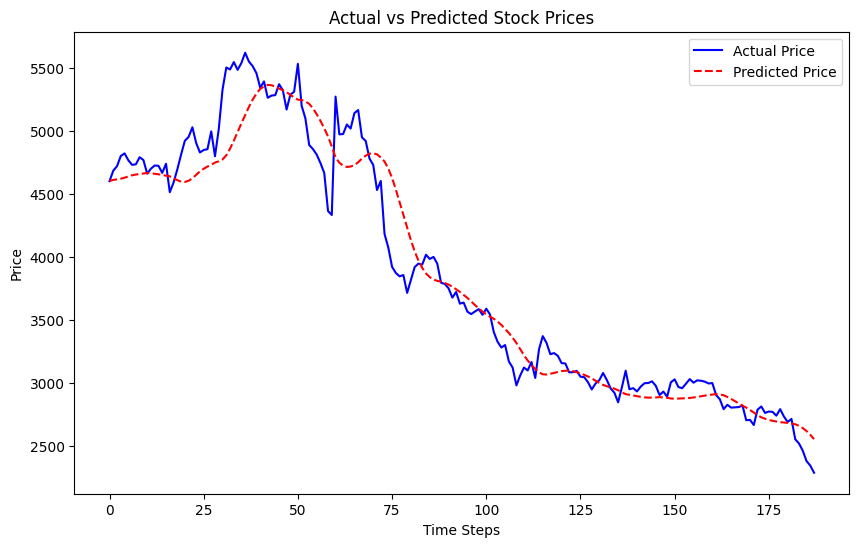

In [9]:
predicted_prices_scaled = model.predict(X)
predicted_prices = scaler.inverse_transform(predicted_prices_scaled)

plot_stock_data(actual_prices[time_steps:], predicted_prices.flatten())

In [10]:
def predict_future_prices(model, data, scaler, time_steps, future_days):

    predictions = []
    last_sequence = data[-time_steps:].reshape(1, time_steps, 1)

    for _ in range(future_days):
        predicted = model.predict(last_sequence, verbose=0)
        predictions.append(predicted[0, 0])

        last_sequence = np.append(last_sequence[:, 1:, :], [[[predicted[0, 0]]]], axis=1)

    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

In [11]:
future_days = 90
predicted_prices = predict_future_prices(model, scaled_data, scaler, time_steps, future_days)

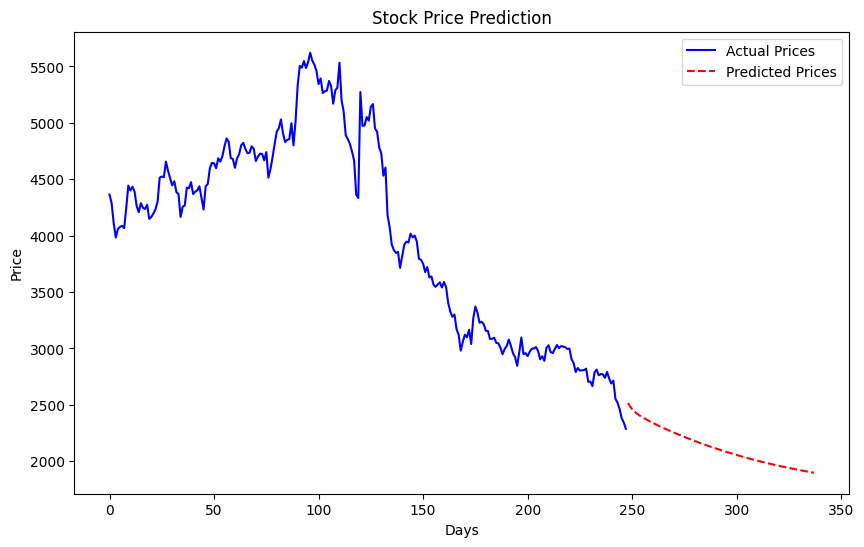

In [12]:
plot_future_predictions(actual_prices, predicted_prices, future_days)